In [30]:
!pip install pydicom
!pip install torchsummary

In [31]:
import warnings
import gc
import os
import random

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import pydicom
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings('ignore')

In [32]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data

In [33]:
root = "/kaggle/input/dl-hw3-pb2/hwk03_data"

train_data = pd.read_csv(os.path.join(root, "train.csv"))
print(f"Numbers of train data : {len(train_data)}")
train_data.head(10)

Numbers of train data : 80


,ID,Disease
0,545876,0
1,517509,0
2,4194,0
3,8098,0
4,230450,0
5,193329,0
6,889904,0
7,1126761,1
8,310883,0
9,347447,0


In [34]:
train_data_label_dist = pd.DataFrame(
    {
        "label" : train_data.iloc[:, 1].value_counts().sort_index().index.astype(str),
        "counts" : train_data.iloc[:, 1].value_counts().sort_index().values
    }
)
train_data_label_dist

,label,counts
0,0,40
1,1,40


## Defined Image Interpolation

In [35]:
# image interpolation
class Interpolate():
    
    def __init__(self, target_num = 22):
        self.target_num = target_num
    
    def __call__(self, slices): # (3, XX, 512, 512) 其中 XX 是切片的數量
        slices = slices.unsqueeze(dim = 0) # (1, 3, XX, 512, 512)
        slices = F.interpolate(
                  slices, 
                  mode = 'trilinear',
                  size = (self.target_num, slices.shape[-2], slices.shape[-1])) # (1, 3, target_num, 512, 512) 其中 slices.shape[-2], slices.shape[-1]為 XX 張 slice 的 H, W
        return torch.transpose(slices.squeeze(), 0, 1) # slices.squeeze()的形狀為 (3, 22, 512, 512)， 經過 transpose 後形狀變為 (22, 3, 512, 512)

## Data Transformation

In [36]:
def build_transform(is_train):
    t = []
    if is_train:       
        t.append(Interpolate(target_num = 22))
        return v2.Compose(t)

    t.append(Interpolate(target_num = 22))
    return v2.Compose(t)

## Evaluator

In [37]:
def evaluator(preds, gts):
    preds = preds.cpu().detach().numpy() 
    gts = gts.cpu().numpy() 
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

## Training

In [38]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, labels in train_loader:
        images = [image.to(device=device, dtype=torch.float) for image in images]
        labels = labels.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        # scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)
        
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1

## Validation

In [39]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = [image.to(device=device, dtype=torch.float) for image in images]
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

## Testing

In [40]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in test_loader:
            
            images = [image.to(device=device, dtype=torch.float) for image in images]
            logits = model(images)
            pred = torch.argmax(logits, dim=1)

            preds.append(pred)


    preds = torch.cat(preds)

    return preds

# 2D CNN
## 2D Dataset

In [41]:
class MRI2DDataset(Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/dl-hw3-pb2/hwk03_data"
        self.ids = np.array(df["ID"])
        self.labels = torch.from_numpy(np.array(df["Disease"]))
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in np.array(df["ID"]):
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(root, "DICOM", path, "T1")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img)
                
                # T2 images
                img = pydicom.dcmread(os.path.join(root, "DICOM", path, "T2", filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0))
                
            slices = torch.stack(all_slices, dim = 1)
            
            if self.transforms:
                slices = self.transforms(slices) 
            
            image = []
            for i in range(len(slices)):
                image.append(slices[i].squeeze().float()) 
            self.images.append(image)
                            
            
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

In [42]:
root = "/kaggle/input/dl-hw3-pb2/hwk03_data"
df = pd.read_csv(os.path.join(root,"train.csv"))
dataset_2D = MRI2DDataset(df = df, mode = "train",transforms = build_transform(True))

print(len(dataset_2D))
print(len(dataset_2D[0])) 
print(len(dataset_2D[0][0])) 
print(dataset_2D[0][0][0].shape) 

# 使用 del 刪除不需要的變數，以釋放出這些變數佔用的 CPU 記憶體。當變數被 del 刪除後，Python 會標記這些記憶體為可回收狀態。
del dataset_2D
# 強制回收內存
gc.collect() 

100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


80
2
22
torch.Size([3, 256, 256])


5982

## Late Fusion

In [49]:
class config:
    
    root = "/kaggle/input/dl-hw3-pb2/hwk03_data"
    valid_prob = 0.2
    batch_size = 4
    lr = 1e-4
    epochs = 20
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


### Late fusion model

In [44]:
# 下方的 Late fusion 是基於這個 VGG16 的 pretrained model 進行修改，Early fusion 和 Single Slice也可用此修改。
vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
print(vgg16)
del vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
class Late_fusion(nn.Module):
    def __init__(self, num_classes, input_size = (3, 256, 256), features_grad = False): 
        super().__init__()

        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
        
        # 將 VGG16 的 classifier 層替換為 nn.Identity()，丟棄預設的分類層。
        vgg16.classifier = nn.Identity()
        
        # 可調整 feature map 的大小，注意到會影響分類層        
        vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        # 固定/不固定特徵層的參數值（features_grad = False / features_grad = True）
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
            
        self.backend = vgg16
        
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Dropout(0.4),
          nn.ReLU(),
          nn.Linear(512 * 1 * 1 * 22, num_classes)
        )

    def forward(self, x): # x: 22 個 (batch_size, 3, 256, 256) 的 list
        
        feature_map_list = []
        for i in range(len(x)):
            feature_map_list.append(self.backend(x[i]))
        feature_map_concentrate = torch.cat(feature_map_list, dim=1)  # shape: (batch_size, 512 * 22, 7, 7)
        feature_map_concentrate = feature_map_concentrate.view(feature_map_concentrate.size(0), -1)  # shape: (batch_size, 512 * 22 * 7 * 7)
        outputs = self.classifier(feature_map_concentrate)

        return outputs

### Parameters of Late fusion model

In [46]:
model_late = Late_fusion(num_classes = 2)
total_params = sum(p.numel() for p in model_late.parameters())
print("總參數量:", total_params)

總參數量: 14737218


### Late fusion 模型測試

In [47]:
# 隨機生成一個 batch size 為 4 、切片大小為（3, 256, 256）的 3D image
x = [torch.randn(4,3,256,256) for _ in range(22)] # x: [(4,3,256,256),...,(4,3,256,256)]
output = model_late(x)
print(output, output.shape)
# 如果輸出一個大小為 torch.Size([4,2]) 的張量，表示測試通過
del model_late
gc.collect()

tensor([[-0.2290,  0.0840],
        [-0.0799, -0.2718],
        [-0.1048, -0.2903],
        [ 0.0339, -0.1267]], grad_fn=<AddmmBackward0>) torch.Size([4, 2])


14

### Late fusion main

In [50]:
def main():

    seed_everything(config.seed)
    
    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    print("Initializing dataset...")  
    train_df = df.iloc[train_ids]
    valid_df = df.iloc[valid_ids]
    train_dataset = MRI2DDataset(train_df, mode = "train",transforms = build_transform(True))
    valid_dataset = MRI2DDataset(valid_df, mode = "valid",transforms = build_transform(False))

    
    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model_late = Late_fusion(num_classes = num_classes, features_grad = True)
    model_late.to(config.device)

    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model_late.parameters() if p.requires_grad] 

    # 選擇適當的 optimizer, scheduler
    optimizer = torch.optim.AdamW(parameters, lr = config.lr, weight_decay = config.weight_decay)
    
    # 以 epoch 為單位來更新學習率
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
#         anneal_strategy = 'cos'
        anneal_strategy = 'linear'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_late, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model_late, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model_late.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Late.pth")

        best_ckpt = torch.load("checkpoint_Late.pth", map_location=config.device)
        model_late.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1 = validation(model_late, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_loader
    del valid_loader
    del train_dataset
    del valid_dataset
    gc.collect()
    # 用於釋放 CUDA GPU 的顯存
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

Initializing dataset...


100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Initializing model...
num_classes 2
Start training!
Epoch[1/20], Train Loss: 3.7888, Train Accuracy: 51.56%, Train F1: 51.46% | Valid Loss: 0.9640, Valid Accuracy: 75.00%, Valid F1: 74.60% | LR: 0.000005
Epoch[2/20], Train Loss: 3.4011, Train Accuracy: 50.00%, Train F1: 49.56% | Valid Loss: 0.9685, Valid Accuracy: 56.25%, Valid F1: 51.52% | LR: 0.000006
Epoch[3/20], Train Loss: 2.5000, Train Accuracy: 56.25%, Train F1: 56.08% | Valid Loss: 0.4427, Valid Accuracy: 81.25%, Valid F1: 81.18% | LR: 0.000007
Epoch[4/20], Train Loss: 1.1729, Train Accuracy: 75.00%, Train F1: 74.98% | Valid Loss: 1.0368, Valid Accuracy: 50.00%, Valid F1: 41.82% | LR: 0.000008
Epoch[5/20], Train Loss: 2.0057, Train Accuracy: 64.06%, Train F1: 62.52% | Valid Loss: 0.2917, Valid Accuracy: 87.50%, Valid F1: 87.50% | LR: 0.000009
Epoch[6/20], Train Loss: 1.6321, Train Accuracy: 59.38%, Train F1: 59.34% | Valid Loss: 0.2562, Valid Accuracy: 81.25%, Valid F1: 81.18% | LR: 0.000010
Epoch[7/20], Train Loss: 0.7830, Tra

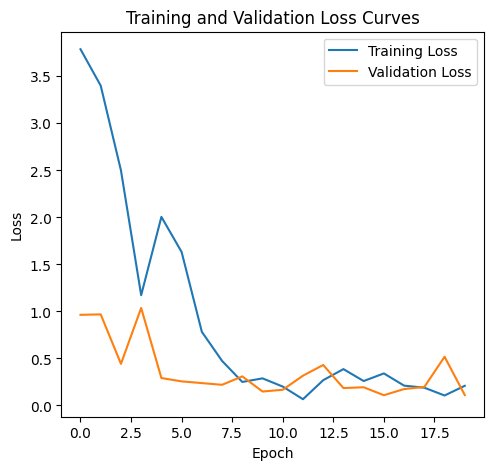

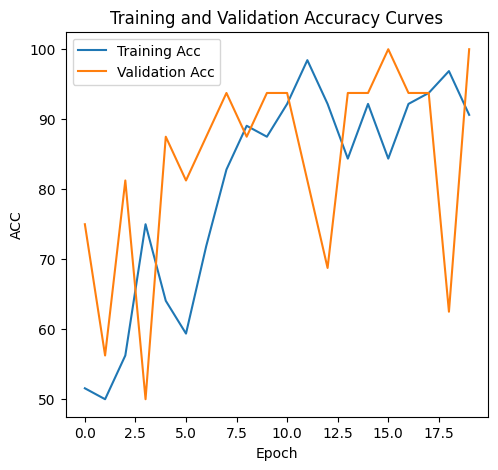

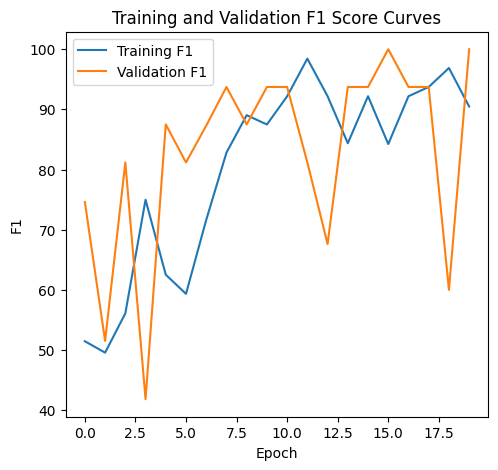

In [51]:
if __name__ == "__main__":
    main()

In [59]:
seed_everything(config.seed)
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))

test_dataset = MRI2DDataset(test_df, mode = "test",transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
model_late = Late_fusion(num_classes = 2, features_grad = True)

model_late.to("cuda")

best_ckpt = torch.load(f"checkpoint_Late.pth")
model_late.load_state_dict(best_ckpt["model"])

preds = testing(model_late, test_loader, config.device)
del test_dataset
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


In [62]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
# results_df.to_csv("/kaggle/working/2D.csv", index=False)
results_df.head(2)

,ID,Disease
0,1035303,0
1,1032110,0


In [67]:
answer_df = pd.read_csv("/kaggle/input/hw3-ans/test_ans_hw3-1.csv")
y_true = answer_df['Disease'] 
y_pred = results_df['Disease']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

Accuracy: 0.725
F1 Score (macro): 0.7163120567375887


In [ ]:
# torch.cuda.empty_cache()